## Import Modules

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

## Load the Dataset

In [26]:
DATASET = 'mma'

TRAIN_DIR = f"input/{DATASET}/train/"
TEST_DIR = f"input/{DATASET}/test/"
VALID_DIR = f"input/{DATASET}/valid/"

In [27]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        # print(label, "Completed")

    return image_paths, labels

In [28]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True) # shuffle

train.head()

,image,label
0,input/mma/train/neutral\75393Exp6amazed_old_52...,neutral
1,input/mma/train/surprise\Surprise.15623.jpg,surprise
2,input/mma/train/happy\47100Exp3amazed_grandmot...,happy
3,input/mma/train/sad\44079Exp4heartbroken_infan...,sad
4,input/mma/train/neutral\Neutral.18281.jpg,neutral


In [29]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1).reset_index(drop=True)

test.head()

,image,label
0,input/mma/test/sad\Sad.19459.jpg,sad
1,input/mma/test/happy\75509Exp3amazed_old_394.jpg,happy
2,input/mma/test/happy\Happy.11807.jpg,happy
3,input/mma/test/neutral\33366Exp6distaste_fathe...,neutral
4,input/mma/test/disgust\31861Exp1disgust_actor_...,disgust


In [30]:
valid = pd.DataFrame()
valid['image'], valid['label'] = load_dataset(VALID_DIR)
valid = valid.sample(frac=1).reset_index(drop=True)

valid.head()

,image,label
0,input/mma/valid/happy\Happy.20127.jpg,happy
1,input/mma/valid/surprise\Surprise.31223.jpg,surprise
2,input/mma/valid/happy\Happy.27618.jpg,happy
3,input/mma/valid/sad\671Exp4angry_boy_654.jpg,sad
4,input/mma/valid/sad\Sad.21022.jpg,sad


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

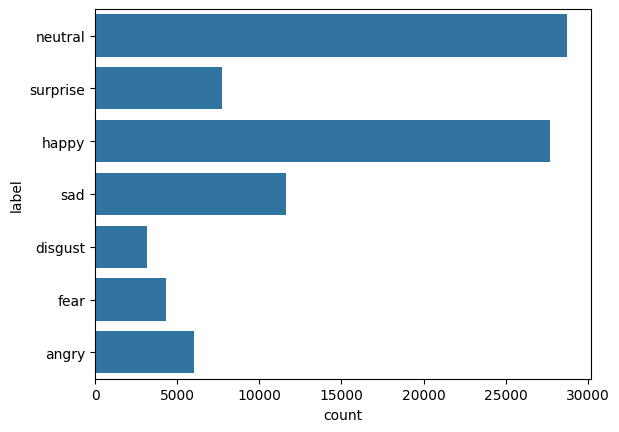

In [31]:
sns.countplot(train['label'])

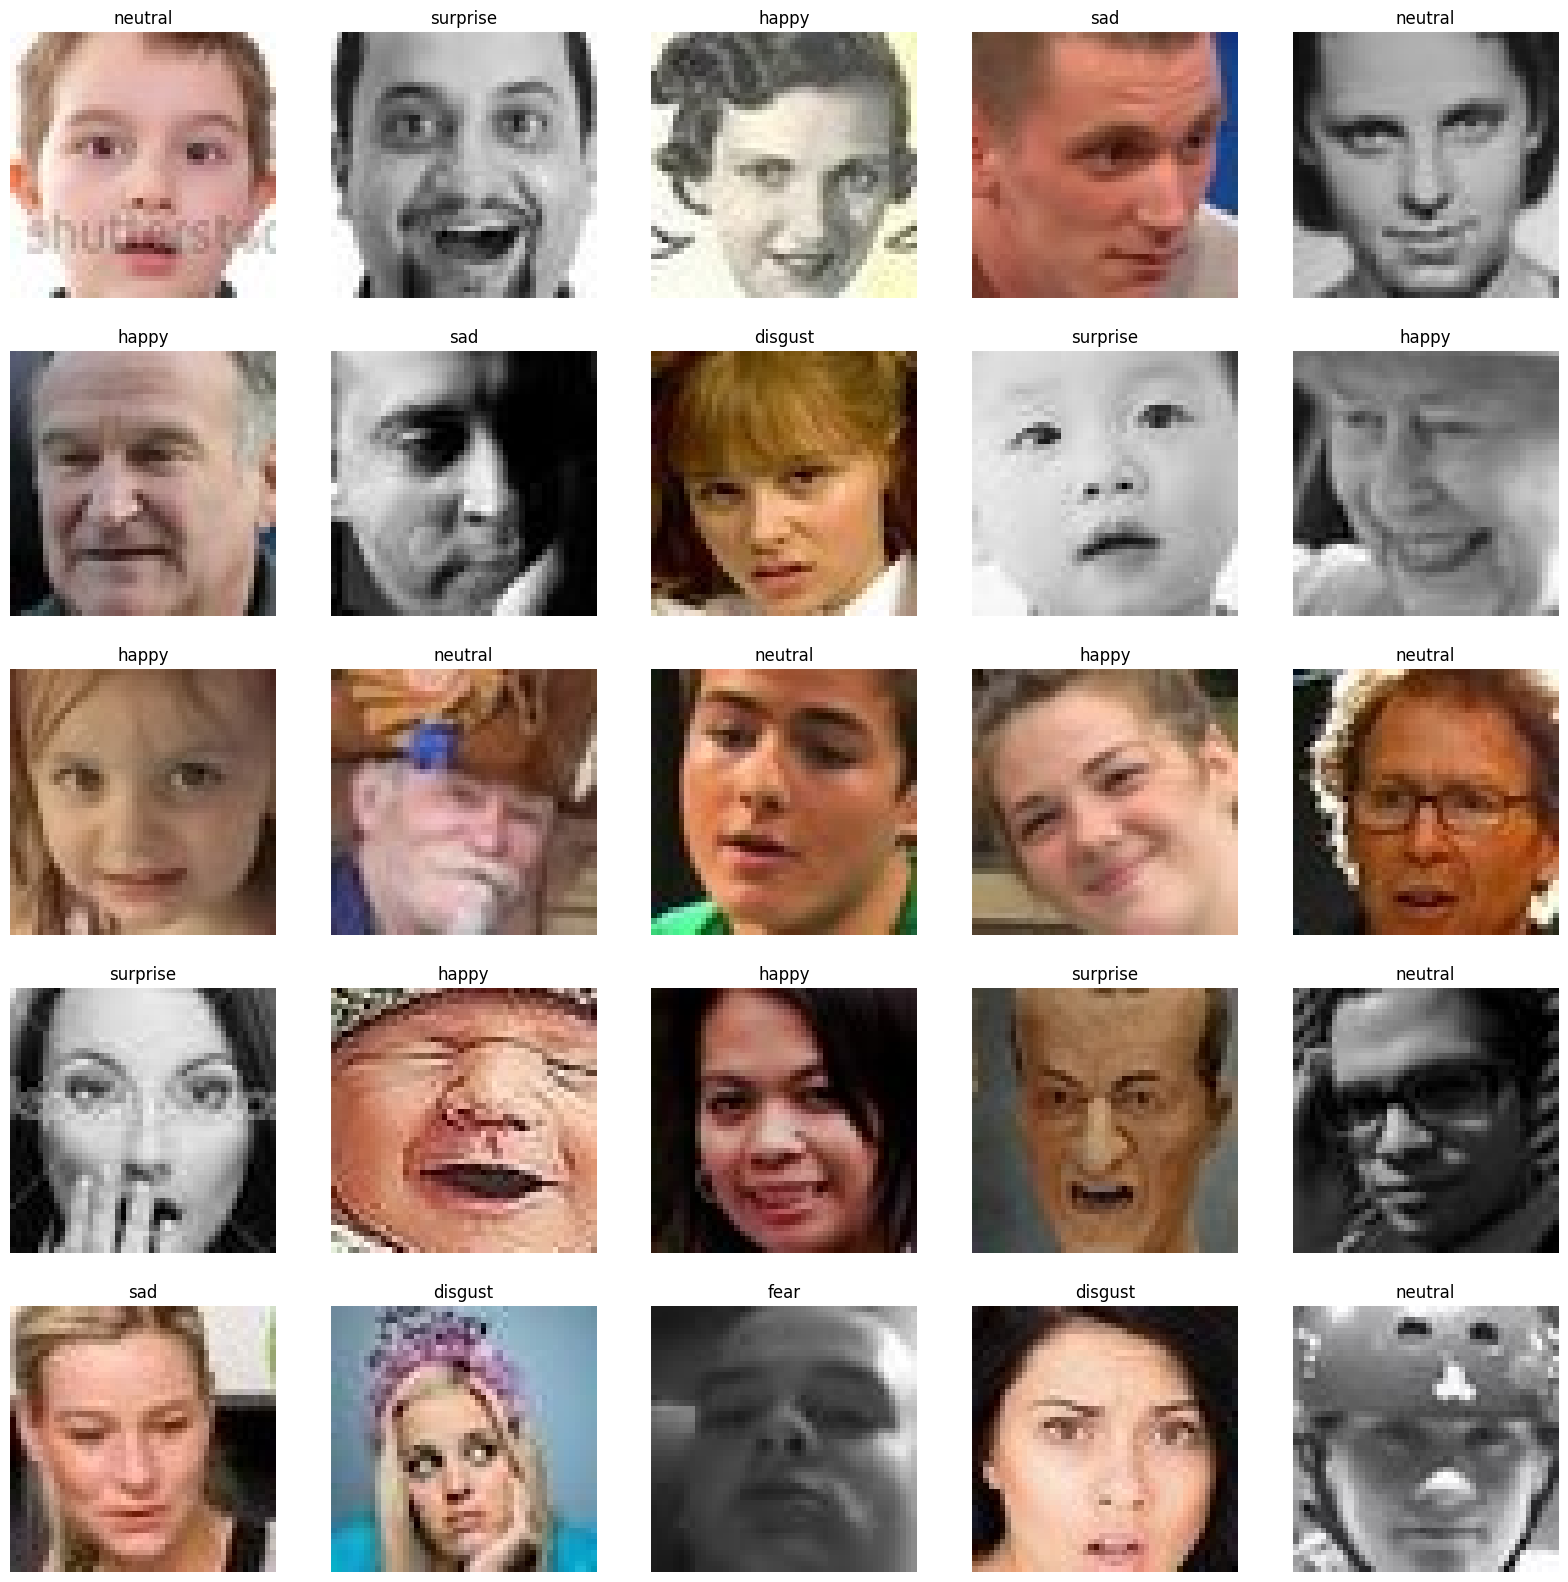

In [32]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, image_path, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(image_path)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [33]:
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale')
        img = np.array(img)
        
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    
    return features

In [34]:
train_features = extract_features(train['image'])
x_train = train_features / 255.0

  0%|          | 0/89373 [00:00<?, ?it/s]

In [35]:
test_features = extract_features(test['image'])
x_test = test_features / 255.0

  0%|          | 0/12767 [00:00<?, ?it/s]

In [36]:
valid_features = extract_features(valid['image'])
x_valid = valid_features / 255.0

  0%|          | 0/25540 [00:00<?, ?it/s]

In [37]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])
y_valid = le.transform(valid['label'])

In [38]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_valid = to_categorical(y_valid, num_classes=7)

In [39]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.])

In [40]:
# config
input_shape = (48, 48, 1)
output_class = 7

## Model Creation

In [41]:
model = Sequential()

# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,232,199 (16.14 MB)

 Trainable params: 4,232,199 (16.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 270s 384ms/step - accuracy: 0.3283 - loss: 1.6555 - val_accuracy: 0.3971 - val_loss: 1.5508
Epoch 2/100
140/699 ━━━━━━━━━━━━━━━━━━━━ 3:18 355ms/step - accuracy: 0.3979 - loss: 1.5497

In [ ]:
# save the model
model.save(f'models/{DATASET}_yt.keras')

## Plot the Results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Accuracy, F1, Precision, Recall

In [ ]:
from sklearn.metrics import classification_report

# Przewidywanie klas na zestawie testowym
y_pred_prob = model.predict(x_test)
y_pred = np.array([np.eye(len(row))[np.argmax(row)] for row in y_pred_prob])

# Obliczenie miar
report = classification_report(y_test, y_pred, target_names=train['label'].unique())

print(report)

## Test with Image Data

In [ ]:
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(5, 5, i+1)

    img_index = random.randint(0, len(test))
    img = x_test[img_index]
    
    label = test['label'][img_index]
    
    pred = model.predict(img.reshape(1, 48, 48, 1), verbose=0)
    pred_lAabel = le.inverse_transform([pred.argmax()])[0]
    print(
    
    plt.title(f"{img_index}. label: {label} | pred: {pred_label}")
    plt.imshow(img.reshape(48, 48), cmap='gray')
    plt.axis('off')